 # Grid Search for Ternary Classification



 This notebook performs grid search optimization for the ternary classification model.

 It searches over:



 1. **Labeling parameters**: horizon, gauss_window, gauss_std

 2. **Feature parameters**: orb_multiplier, coord_mode (geo/helio/both)

 3. **Model hyperparameters**: max_depth, learning_rate, weight_power



 Uses caching to avoid recomputation of intermediate data.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# ENVIRONMENT CHECK & PATH SETUP
# ═══════════════════════════════════════════════════════════════════════════════════
# We need to find the project root directory and add it to Python's path.
# This allows us to import our custom RESEARCH modules from anywhere.
# ═══════════════════════════════════════════════════════════════════════════════════

import sys
from pathlib import Path

# Find project root by looking for RESEARCH folder
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "RESEARCH").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "RESEARCH").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Python: {sys.version}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")


Python: 3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:25:55) [GCC 14.3.0]
PROJECT_ROOT: /home/rut/ostrofun


 ## 1. Setup & Configuration

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# IMPORTS
# ═══════════════════════════════════════════════════════════════════════════════════
import itertools
import time
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Any, Optional

import numpy as np
import pandas as pd
# NOTE: tqdm removed - causes output blocking in notebooks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# RESEARCH modules
from RESEARCH.config import cfg, PROJECT_ROOT
from RESEARCH.data_loader import load_market_data
from RESEARCH.labeling import create_ternary_labels
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates_multi,
    calculate_aspects_for_dates,
    calculate_phases_for_dates,
)
from RESEARCH.features import (
    build_full_features,
    merge_features_with_labels,
    get_feature_columns,
)
from RESEARCH.model_training import (
    split_dataset,
    prepare_xy,
    train_xgb_model,
    calc_metrics,
    check_cuda_available,
    compute_stronger_weights,
)
from RESEARCH.cache_utils import (
    save_cache,
    load_cache,
    cache_exists,
    list_cache,
    get_cache_path,
)

print("✓ All modules imported")


✓ All modules imported


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# GRID SEARCH CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════════
# Define all parameter grids to search over.
# Keep grids small for initial exploration, expand later.
# ═══════════════════════════════════════════════════════════════════════════════════

# ─────────────────────────────────────────────────────────────────────────────────
# DATA PARAMETERS (fixed for this search)
# ─────────────────────────────────────────────────────────────────────────────────
DATA_START = "2017-11-01"  # Bitcoin price history start

# ─────────────────────────────────────────────────────────────────────────────────
# LABELING PARAMETERS GRID
# ─────────────────────────────────────────────────────────────────────────────────
# horizon: How many days ahead we're predicting
# gauss_window: Size of Gaussian smoothing window (must be odd)
# gauss_std: Standard deviation of Gaussian
LABEL_GRID = {
    "horizon": [1,],            # 1, 3, or 5 days ahead
    "gauss_window": [101, 201], # Smoothing window sizes
    "gauss_std": [50.0, 100.0], # Gaussian std
}

# ─────────────────────────────────────────────────────────────────────────────────
# FEATURE PARAMETERS GRID
# ─────────────────────────────────────────────────────────────────────────────────
# coord_mode: 'geo' (Earth-centered), 'helio' (Sun-centered), or 'both'
# orb_multiplier: Scale for aspect orbs (lower = stricter)
FEATURE_GRID = {
    "coord_mode": ["geo", "helio",  "both"],           # Start with both geo+helio
    "orb_multiplier": [0.15,], # Aspect orb scaling
    "include_phases": [True],          # Always include moon phases
}

# ─────────────────────────────────────────────────────────────────────────────────
# MODEL HYPERPARAMETERS GRID
# ─────────────────────────────────────────────────────────────────────────────────
MODEL_GRID = {
    "max_depth": [3, 5, 9],              # Tree depth
    "learning_rate": [0.01, 0.03, 0.05], # Step size
    "weight_power": [2.0],               # Fixed (use sideways_penalty instead)
    "sideways_penalty": [0.3, 0.5, 1.0], # NEW: reduce SIDEWAYS weight (0.3 = -70%)
    "n_estimators": [500],               # Fixed
    "subsample": [0.8],                  # Fixed
    "colsample_bytree": [0.8],           # Fixed
}

# ─────────────────────────────────────────────────────────────────────────────────
# SEARCH SETTINGS
# ─────────────────────────────────────────────────────────────────────────────────
# Set to True for quick test run with reduced grid
TEST_MODE = False # Set to False for full search

if TEST_MODE:
    print("⚠️ TEST MODE: Using reduced grid for quick testing")
    LABEL_GRID = {
        "horizon": [1],
        "gauss_window": [201],
        "gauss_std": [50.0],
    }
    FEATURE_GRID = {
        "coord_mode": ["both"],
        "orb_multiplier": [1.0],
        "include_phases": [True],
    }
    MODEL_GRID = {
        "max_depth": [4],
        "learning_rate": [0.03],
        "weight_power": [1.5, 2.0],
        "n_estimators": [300],
        "subsample": [0.8],
        "colsample_bytree": [0.8],
    }


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CALCULATE TOTAL COMBINATIONS
# ═══════════════════════════════════════════════════════════════════════════════════

def count_combinations(grid: Dict[str, List]) -> int:
    """Count total combinations in a parameter grid."""
    total = 1
    for values in grid.values():
        total *= len(values)
    return total

label_combos = count_combinations(LABEL_GRID)
feature_combos = count_combinations(FEATURE_GRID)
model_combos = count_combinations(MODEL_GRID)
total_combos = label_combos * feature_combos * model_combos

print(f"\nGrid Search Statistics:")
print(f"  Label combinations:   {label_combos}")
print(f"  Feature combinations: {feature_combos}")
print(f"  Model combinations:   {model_combos}")
print(f"  ─────────────────────────────")
print(f"  TOTAL COMBINATIONS:   {total_combos}")



Grid Search Statistics:
  Label combinations:   4
  Feature combinations: 3
  Model combinations:   27
  ─────────────────────────────
  TOTAL COMBINATIONS:   324


 ## 2. Load Market Data

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# LOAD MARKET DATA (WITH CACHING)
# ═══════════════════════════════════════════════════════════════════════════════════

MARKET_CACHE_PARAMS = {
    "subject_id": cfg.active_subject_id,
    "start_date": DATA_START,
}

df_market = load_cache("market", "data", MARKET_CACHE_PARAMS, verbose=True)

if df_market is None:
    print("Loading from database...")
    df_market = load_market_data()
    df_market = df_market[df_market["date"] >= DATA_START].reset_index(drop=True)
    save_cache(df_market, "market", "data", MARKET_CACHE_PARAMS)

print(f"\nMarket data: {len(df_market)} rows")
print(f"Date range: {df_market['date'].min().date()} → {df_market['date'].max().date()}")


📂 Loading from cache: market__data__btc_2017-11-01__8d63944e.parquet

Market data: 3014 rows
Date range: 2017-11-01 → 2026-01-31


 ## 3. Initialize Ephemeris

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# INITIALIZE ASTRO SETTINGS
# ═══════════════════════════════════════════════════════════════════════════════════

settings = init_ephemeris()
print(f"Bodies: {[b.name for b in settings.bodies]}")

# Check CUDA availability
use_cuda, device = check_cuda_available()
print(f"Device: {device}")


Bodies: ['Sun', 'Moon', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', 'TrueNode', 'MeanNode', 'Lilith']
Device: cuda


 ## 4. Grid Search Functions

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# GRID SEARCH HELPER FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════════

def generate_grid_combinations(grid: Dict[str, List]) -> List[Dict[str, Any]]:
    """
    Generate all combinations of parameter values from a grid.
    
    Args:
        grid: Dictionary of parameter_name -> list of values
    
    Returns:
        List of dictionaries, each containing one combination
    
    Example:
        grid = {"a": [1, 2], "b": ["x", "y"]}
        result = [{"a": 1, "b": "x"}, {"a": 1, "b": "y"}, ...]
    """
    keys = list(grid.keys())
    values = list(grid.values())
    
    combinations = []
    for combo in itertools.product(*values):
        combinations.append(dict(zip(keys, combo)))
    
    return combinations


def get_or_compute_labels(
    df_market: pd.DataFrame,
    label_params: Dict,
) -> pd.DataFrame:
    """
    Get labels from cache or compute them.
    
    This is the first step where caching saves the most time,
    since label computation involves detrending which is slow.
    """
    cache_params = {
        "subject_id": cfg.active_subject_id,
        "start_date": DATA_START,
        "type": "ternary",
        **label_params,
    }
    
    # Try cache
    df_labels = load_cache("labels", "ternary", cache_params, verbose=False)
    
    if df_labels is None:
        # Compute
        df_labels, threshold = create_ternary_labels(
            df_market,
            horizon=label_params["horizon"],
            gauss_window=label_params["gauss_window"],
            gauss_std=label_params["gauss_std"],
            balance_classes=True,
            verbose=False,
        )
        save_cache(df_labels, "labels", "ternary", cache_params, verbose=False)
    
    return df_labels


def get_or_compute_features(
    df_market: pd.DataFrame,
    settings,
    feature_params: Dict,
) -> pd.DataFrame:
    """
    Get features from cache or compute them.
    
    Features are the most expensive to compute (bodies + aspects + phases).
    Caching here saves significant time in grid search.
    """
    date_range = f"{df_market['date'].min().date()}_{df_market['date'].max().date()}"
    
    cache_params = {
        "coord_mode": feature_params["coord_mode"],
        "orb_mult": feature_params["orb_multiplier"],
        "include_phases": feature_params["include_phases"],
        "date_range": date_range,
    }
    
    # Try cache for complete feature set
    df_features = load_cache("features", "ternary", cache_params, verbose=False)
    
    if df_features is None:
        # ─────────────────────────────────────────────────────────────────────────
        # Compute bodies (most time-consuming)
        # ─────────────────────────────────────────────────────────────────────────
        bodies_cache_params = {
            "coord_mode": feature_params["coord_mode"],
            "date_range": date_range,
        }
        
        df_bodies = load_cache("astro", "bodies", bodies_cache_params, verbose=False)
        geo_by_date = load_cache("astro", "bodies_geo_dict", bodies_cache_params, verbose=False)
        helio_by_date = load_cache("astro", "bodies_helio_dict", bodies_cache_params, verbose=False)
        
        # If bodies not cached, compute them
        if df_bodies is None:
            df_bodies, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
                df_market["date"],
                settings,
                coord_mode=feature_params["coord_mode"],
                progress=False,
            )
            save_cache(df_bodies, "astro", "bodies", bodies_cache_params, verbose=False)
            save_cache(geo_by_date, "astro", "bodies_geo_dict", bodies_cache_params, verbose=False)
            if helio_by_date:
                save_cache(helio_by_date, "astro", "bodies_helio_dict", bodies_cache_params, verbose=False)
        
        # ─────────────────────────────────────────────────────────────────────────
        # Compute aspects (needs geo_by_date)
        # ─────────────────────────────────────────────────────────────────────────
        aspects_cache_params = {
            "orb_mult": feature_params["orb_multiplier"],
            "coord_mode": feature_params["coord_mode"],
            "date_range": date_range,
        }
        
        df_aspects = load_cache("astro", "aspects", aspects_cache_params, verbose=False)
        
        # Only compute if not cached AND we have geo_by_date
        if df_aspects is None:
            if geo_by_date is not None:
                df_aspects = calculate_aspects_for_dates(
                    geo_by_date,
                    settings,
                    orb_mult=feature_params["orb_multiplier"],
                    progress=False,
                )
                save_cache(df_aspects, "astro", "aspects", aspects_cache_params, verbose=False)
            else:
                # Create empty aspects DataFrame if geo_by_date not available
                df_aspects = pd.DataFrame(columns=["date"])
        
        # ─────────────────────────────────────────────────────────────────────────
        # Compute phases
        # ─────────────────────────────────────────────────────────────────────────
        phases_cache_params = {"date_range": date_range}
        
        df_phases = None
        if feature_params["include_phases"]:
            df_phases = load_cache("astro", "phases", phases_cache_params, verbose=False)
            
            if df_phases is None and geo_by_date is not None:
                df_phases = calculate_phases_for_dates(geo_by_date, progress=False)
                save_cache(df_phases, "astro", "phases", phases_cache_params, verbose=False)
        
        # ─────────────────────────────────────────────────────────────────────────
        # Build feature matrix
        # ─────────────────────────────────────────────────────────────────────────
        df_features = build_full_features(
            df_bodies,
            df_aspects,
            df_phases=df_phases,
            include_pair_aspects=True,
        )
        
        save_cache(df_features, "features", "ternary", cache_params, verbose=False)
    
    return df_features


def run_single_experiment(
    df_dataset: pd.DataFrame,
    model_params: Dict,
    device: str,
) -> Dict:
    """
    Run a single training experiment with given parameters.
    
    Returns metrics on test set.
    """
    # ─────────────────────────────────────────────────────────────────────────────
    # Split data
    # ─────────────────────────────────────────────────────────────────────────────
    train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)
    
    feature_cols = get_feature_columns(df_dataset)
    X_train, y_train = prepare_xy(train_df, feature_cols)
    X_val, y_val = prepare_xy(val_df, feature_cols)
    X_test, y_test = prepare_xy(test_df, feature_cols)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Extract weight_power from model_params
    # ─────────────────────────────────────────────────────────────────────────────
    weight_power = model_params.pop("weight_power", 2.0)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Train model
    # ─────────────────────────────────────────────────────────────────────────────
    model = train_xgb_model(
        X_train, y_train,
        X_val, y_val,
        feature_cols,
        n_classes=3,
        device=device,
        weight_power=weight_power,
        verbose=False,
        **model_params,
    )
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Evaluate on test set
    # ─────────────────────────────────────────────────────────────────────────────
    X_test_scaled = model.scaler.transform(X_test)
    y_proba = model.model.predict_proba(X_test_scaled)
    y_pred = y_proba.argmax(axis=1)
    
    metrics = calc_metrics(y_test, y_pred, labels=[0, 1, 2])
    
    # Add weight_power back for logging
    model_params["weight_power"] = weight_power
    
    return metrics



In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# EVALUATION & VISUALIZATION FUNCTION
# ═══════════════════════════════════════════════════════════════════════════════════
# This function can be called:
#   - BEFORE grid search as baseline
#   - AFTER grid search with best model
# ═══════════════════════════════════════════════════════════════════════════════════

def evaluate_and_visualize_model(
    model,
    X_test: np.ndarray,
    y_test: np.ndarray,
    df_test: pd.DataFrame,
    title: str = "Model Evaluation",
) -> Dict:
    """
    ═══════════════════════════════════════════════════════════════════════════════
    COMPREHENSIVE MODEL EVALUATION WITH VISUALIZATIONS
    ═══════════════════════════════════════════════════════════════════════════════
    
    Displays:
    1. All metrics (accuracy, balanced accuracy, MCC, F1, per-class recalls)
    2. Confusion matrix heatmap
    3. Two price charts with class labels:
       - Top: TRUE labels (from data)
       - Bottom: PREDICTED labels (from model)
    
    Args:
        model: Trained XGBBaseline model
        X_test: Test features (NOT scaled)
        y_test: True labels
        df_test: Test DataFrame with 'date' and 'close' columns
        title: Title for the evaluation
    
    Returns:
        Dictionary with all metrics
    ═══════════════════════════════════════════════════════════════════════════════
    """
    # ─────────────────────────────────────────────────────────────────────────────
    # Get predictions
    # ─────────────────────────────────────────────────────────────────────────────
    X_test_scaled = model.scaler.transform(X_test)
    y_proba = model.model.predict_proba(X_test_scaled)
    y_pred = y_proba.argmax(axis=1)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Calculate metrics
    # ─────────────────────────────────────────────────────────────────────────────
    metrics = calc_metrics(y_test, y_pred, labels=[0, 1, 2])
    
    CLASS_NAMES = ["DOWN", "SIDEWAYS", "UP"]
    
    print("\n" + "=" * 80)
    print(f"  {title}")
    print("=" * 80)
    
    print("\n📊 METRICS:")
    print(f"  Accuracy:          {metrics['acc']:.4f}")
    print(f"  Balanced Accuracy: {metrics['bal_acc']:.4f}")
    print(f"  MCC:               {metrics['mcc']:.4f}")
    print(f"  F1 Macro:          {metrics['f1_macro']:.4f}")
    
    print("\n📈 PER-CLASS RECALL:")
    print(f"  DOWN (0):     {metrics['recall_down']:.4f}")
    
    # Calculate SIDEWAYS recall manually
    mask_sideways = (y_test == 1)
    recall_sideways = (y_pred[mask_sideways] == 1).sum() / mask_sideways.sum() if mask_sideways.sum() > 0 else 0
    print(f"  SIDEWAYS (1): {recall_sideways:.4f}")
    print(f"  UP (2):       {metrics['recall_up']:.4f}")
    
    print(f"\n🎯 RECALL MIN:  {metrics['recall_min']:.4f} (quality)")
    print(f"   RECALL GAP:  {metrics['recall_gap']:.4f} (balance)")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Classification report
    # ─────────────────────────────────────────────────────────────────────────────
    print("\n📋 CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Create figure with 3 subplots
    # ─────────────────────────────────────────────────────────────────────────────
    plt.style.use('default')
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), facecolor='white')
    for ax in axes:
        ax.set_facecolor('white')
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Subplot 1: Confusion Matrix
    # ─────────────────────────────────────────────────────────────────────────────
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
        ax=axes[0]
    )
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].set_title(f"Confusion Matrix | Bal.Acc={metrics['bal_acc']:.3f}, Recall MIN={metrics['recall_min']:.3f}")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Subplot 2: Price with TRUE labels
    # ─────────────────────────────────────────────────────────────────────────────
    dates = df_test["date"].values
    prices = df_test["close"].values
    
    # Color mapping: DOWN=red, SIDEWAYS=gray, UP=green
    COLORS = {0: "#e63946", 1: "#FFFAFA", 2: "#2d6a4f"}
    
    ax = axes[1]
    ax.plot(dates, prices, color="black", linewidth=1, alpha=0.8)
    
    # Fill background with true class colors
    for i in range(len(dates) - 1):
        ax.axvspan(dates[i], dates[i+1], alpha=0.3, color=COLORS[y_test[i]], linewidth=0)
    
    ax.set_title("TRUE Labels (Ground Truth)")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS[0], alpha=0.5, label="DOWN"),
        Patch(facecolor=COLORS[1], alpha=0.5, label="SIDEWAYS"),
        Patch(facecolor=COLORS[2], alpha=0.5, label="UP"),
    ]
    ax.legend(handles=legend_elements, loc="upper left")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Subplot 3: Price with PREDICTED labels
    # ─────────────────────────────────────────────────────────────────────────────
    ax = axes[2]
    ax.plot(dates, prices, color="black", linewidth=1, alpha=0.8)
    
    # Fill background with predicted class colors
    for i in range(len(dates) - 1):
        ax.axvspan(dates[i], dates[i+1], alpha=0.3, color=COLORS[y_pred[i]], linewidth=0)
    
    ax.set_title("PREDICTED Labels (Model Output)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend(handles=legend_elements, loc="upper left")
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=14, fontweight="bold", y=1.02)
    plt.show()
    
    return metrics


def train_and_evaluate_full(
    df_dataset: pd.DataFrame,
    model_params: Dict,
    device: str,
    title: str = "Model Evaluation",
    df_market: pd.DataFrame = None,
) -> Dict:
    """
    Convenience function: train model and run full evaluation.
    
    Use this for baseline comparison before grid search
    and for final evaluation after grid search.
    
    Args:
        df_dataset: Dataset with features and labels
        model_params: Model hyperparameters
        device: 'cpu' or 'cuda'
        title: Title for plots
        df_market: Original market data with 'close' column (for visualization)
    """
    # Split data
    train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Add 'close' column if missing (needed for price chart)
    # ─────────────────────────────────────────────────────────────────────────────
    if "close" not in test_df.columns and df_market is not None:
        test_df = test_df.merge(
            df_market[["date", "close"]], 
            on="date", 
            how="left"
        )
    elif "close" not in test_df.columns:
        # Create dummy price column if df_market not provided
        test_df = test_df.copy()
        test_df["close"] = 1.0  # Placeholder
    
    feature_cols = get_feature_columns(df_dataset)
    X_train, y_train = prepare_xy(train_df, feature_cols)
    X_val, y_val = prepare_xy(val_df, feature_cols)
    X_test, y_test = prepare_xy(test_df, feature_cols)
    
    # Extract weight_power
    weight_power = model_params.pop("weight_power", 2.0) if "weight_power" in model_params else 2.0
    
    # Train model
    print(f"Training model with weight_power={weight_power}...")
    model = train_xgb_model(
        X_train, y_train,
        X_val, y_val,
        feature_cols,
        n_classes=3,
        device=device,
        weight_power=weight_power,
        verbose=False,
        **model_params,
    )
    
    # Evaluate
    metrics = evaluate_and_visualize_model(model, X_test, y_test, test_df, title)
    
    return metrics, model



 ## 5. Run Grid Search

In [25]:
# ═══════════════════════════════════════════════════════════════════════════════════
# RUN GRID SEARCH
# ═══════════════════════════════════════════════════════════════════════════════════

# Generate all parameter combinations
label_combos_list = generate_grid_combinations(LABEL_GRID)
feature_combos_list = generate_grid_combinations(FEATURE_GRID)
model_combos_list = generate_grid_combinations(MODEL_GRID)

print(f"\nStarting grid search with {total_combos} combinations...")
print(f"Device: {device}")
start_time = time.time()

# Results storage
results = []

# Track best result for up_down balance
best_up_down_min = 0.0
best_params_str = ""

# ─────────────────────────────────────────────────────────────────────────────────
# CHECKPOINT SAVING: Save results every N tests to avoid losing progress
# ─────────────────────────────────────────────────────────────────────────────────
CHECKPOINT_EVERY = 50  # Save checkpoint every 50 tests
checkpoint_dir = PROJECT_ROOT / "RESEARCH" / "reports"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "grid_search_checkpoint.csv"
print(f"💾 Checkpoint will save every {CHECKPOINT_EVERY} tests to: {checkpoint_path.name}")

# Progress tracking (no tqdm - avoids notebook blocking)
test_count = 0
strr =""
for label_params in label_combos_list:
    # ─────────────────────────────────────────────────────────────────────────────
    # Get or compute labels for this configuration
    # ─────────────────────────────────────────────────────────────────────────────
    df_labels = get_or_compute_labels(df_market, label_params)
    
    for feature_params in feature_combos_list:
        # ─────────────────────────────────────────────────────────────────────────
        # Get or compute features for this configuration
        # ─────────────────────────────────────────────────────────────────────────
        df_features = get_or_compute_features(df_market, settings, feature_params)
        
        # ─────────────────────────────────────────────────────────────────────────
        # Merge features with labels
        # ─────────────────────────────────────────────────────────────────────────
        df_dataset = merge_features_with_labels(df_features, df_labels)
        
        for model_params in model_combos_list:
            try:
                # ─────────────────────────────────────────────────────────────────
                # Run experiment
                # ─────────────────────────────────────────────────────────────────
                model_params_copy = model_params.copy()  # Don't modify original
                metrics = run_single_experiment(df_dataset, model_params_copy, device)
                
                # ─────────────────────────────────────────────────────────────────
                # Calculate UP/DOWN balance metrics
                # ─────────────────────────────────────────────────────────────────
                up_down_min = min(metrics["recall_down"], metrics["recall_up"])
                up_down_gap = abs(metrics["recall_down"] - metrics["recall_up"])
                
                # ─────────────────────────────────────────────────────────────────
                # Store results
                # ─────────────────────────────────────────────────────────────────
                result = {
                    **label_params,
                    **feature_params,
                    **model_params,
                    "bal_acc": metrics["bal_acc"],
                    "f1_macro": metrics["f1_macro"],
                    "mcc": metrics["mcc"],
                    "recall_down": metrics["recall_down"],
                    "recall_up": metrics["recall_up"],
                    "recall_min": metrics["recall_min"],
                    "recall_gap": metrics["recall_gap"],
                    # NEW: UP/DOWN balance metrics
                    "up_down_min": up_down_min,
                    "up_down_gap": up_down_gap,
                }
                results.append(result)
                
                # ─────────────────────────────────────────────────────────────────
                # Format short params string
                # ─────────────────────────────────────────────────────────────────
                params_short = (
                    f"h={label_params.get('horizon', '?')}, "
                    f"gw={label_params.get('gauss_window', '?')}, "
                    f"orb={feature_params.get('orb_multiplier', '?')}, "
                    f"coord={feature_params.get('coord_mode', '?')[:3]}, "
                    f"depth={model_params.get('max_depth', '?')}, "
                    f"lr={model_params.get('learning_rate', '?')}, "
                    f"wp={model_params.get('weight_power', '?')}, sp={model_params.get('sideways_penalty', '?')}"
                )
                
                # ─────────────────────────────────────────────────────────────────
                # Print current result with metrics
                # ─────────────────────────────────────────────────────────────────
                test_count += 1
                print(
                    f"[{test_count:4d}/{total_combos}] D={metrics['recall_down']:.2f} U={metrics['recall_up']:.2f} "
                    f"| ud_min={up_down_min:.2f} gap={up_down_gap:.2f} "
                    f"| {params_short}"
                )
                
                # ─────────────────────────────────────────────────────────────────
                # Check if new best (by up_down_min)
                # ─────────────────────────────────────────────────────────────────
                
                if up_down_min > best_up_down_min:
                    best_up_down_min = up_down_min
                    best_params_str = params_short
                    strr = f"  ⭐ NEW BEST! up_down_min={up_down_min:.3f} | {params_short}"
                
                print(strr)
                # ─────────────────────────────────────────────────────────────────
                # CHECKPOINT: Save results every N tests
                # ─────────────────────────────────────────────────────────────────
                if len(results) % CHECKPOINT_EVERY == 0:
                    df_checkpoint = pd.DataFrame(results)
                    df_checkpoint.to_csv(checkpoint_path, index=False)
                    print(f"  💾 Checkpoint saved: {len(results)} results → {checkpoint_path.name}")
                
            except Exception as e:
                test_count += 1
                print(f"[{test_count:4d}/{total_combos}] ⚠️ Error: {e}")

elapsed = time.time() - start_time
print(f"\n✓ Grid search completed in {elapsed/60:.1f} minutes")
print(f"\n🏆 BEST BY UP/DOWN BALANCE: up_down_min={best_up_down_min:.3f}")
print(f"   Params: {best_params_str}")



Starting grid search with 324 combinations...
Device: cuda
💾 Checkpoint will save every 50 tests to: grid_search_checkpoint.csv
Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 91
Split: Train=2109, Val=452, Test=453
[   1/324] D=0.49 U=0.00 | ud_min=0.00 gap=0.49 | h=1, gw=101, orb=0.15, coord=geo, depth=3, lr=0.01, wp=2.0, sp=0.3

Split: Train=2109, Val=452, Test=453
[   2/324] D=0.98 U=0.00 | ud_min=0.00 gap=0.98 | h=1, gw=101, orb=0.15, coord=geo, depth=3, lr=0.01, wp=2.0, sp=0.5

Split: Train=2109, Val=452, Test=453
[   3/324] D=0.83 U=0.00 | ud_min=0.00 gap=0.83 | h=1, gw=101, orb=0.15, coord=geo, depth=3, lr=0.01, wp=2.0, sp=1.0

Split: Train=2109, Val=452, Test=453
[   4/324] D=0.59 U=0.00 | ud_min=0.00 gap=0.59 | h=1, gw=101, orb=0.15, coord=geo, depth=3, lr=0.03, wp=2.0, sp=0.3

Split: Train=2109, Val=452, Test=453
[   5/324] D=0.64 U=0.00 | ud_min=0.00 gap=0.64 | h=1, gw=101, orb=0.15, coord=geo, depth=3, lr=0.03, wp=2.0, sp=0.5

Split: Train=2109, Val=452,

KeyboardInterrupt: 

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# ANALYZE RESULTS
# ═══════════════════════════════════════════════════════════════════════════════════

df_results = pd.DataFrame(results)

if not df_results.empty:
    # ─────────────────────────────────────────────────────────────────────────────
    # TOP 10 BY UP/DOWN BALANCE (most important for trading!)
    # ─────────────────────────────────────────────────────────────────────────────
    print("\n" + "=" * 80)
    print("🏆 TOP 10 BY UP/DOWN BALANCE (best for trading)")
    print("=" * 80)
    
    display_cols_balance = [
        "horizon", "orb_multiplier", "coord_mode", "weight_power",
        "max_depth", "learning_rate",
        "recall_down", "recall_up", "up_down_min", "up_down_gap"
    ]
    
    df_by_balance = df_results.sort_values(
        ["up_down_min", "up_down_gap"], 
        ascending=[False, True]  # max up_down_min, min up_down_gap
    )
    print(df_by_balance[display_cols_balance].head(10).to_string(index=False))
    
    # ─────────────────────────────────────────────────────────────────────────────
    # TOP 10 BY BALANCED ACCURACY
    # ─────────────────────────────────────────────────────────────────────────────
    print("\n" + "=" * 80)
    print("TOP 10 BY BALANCED ACCURACY")
    print("=" * 80)
    
    display_cols = [
        "horizon", "orb_multiplier", "coord_mode", "weight_power",
        "max_depth", "learning_rate",
        "bal_acc", "f1_macro", "recall_min", "recall_gap"
    ]
    
    df_by_acc = df_results.sort_values("bal_acc", ascending=False)
    print(df_by_acc[display_cols].head(10).to_string(index=False))
    
    print("\n" + "=" * 80)
    print("TOP 10 BY RECALL_MIN (all 3 classes balanced)")
    print("=" * 80)
    
    df_by_recall = df_results.sort_values(
        ["recall_min", "recall_gap"], 
        ascending=[False, True]
    )
    print(df_by_recall[display_cols].head(10).to_string(index=False))
else:
    print("⚠️ No results to analyze")



🏆 TOP 10 BY UP/DOWN BALANCE (best for trading)
 horizon  orb_multiplier coord_mode  weight_power  max_depth  learning_rate  recall_down  recall_up  up_down_min  up_down_gap
       1            0.15      helio           2.0          9           0.03     0.480198   0.500000     0.480198     0.019802
       1            0.15      helio           2.0          9           0.03     0.480583   0.444444     0.444444     0.036138
       1            0.15      helio           2.0          5           0.05     0.420792   0.416667     0.416667     0.004125
       1            0.15      helio           2.0          9           0.01     0.402913   0.644444     0.402913     0.241532
       1            0.15       both           2.0          9           0.05     0.422886   0.382979     0.382979     0.039907
       1            0.15        geo           2.0          9           0.05     0.356436   0.500000     0.356436     0.143564
       1            0.15      helio           2.0          9          

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SAVE RESULTS TO CSV
# ═══════════════════════════════════════════════════════════════════════════════════
# SORT BY UP/DOWN BALANCE
if not df_results.empty and "up_down_min" in df_results.columns:
    df_results = df_results.sort_values(
        ["up_down_min", "up_down_gap"], 
        ascending=[False, True]
    ).reset_index(drop=True)
    print(f"✓ Sorted by up_down_min. Best: {df_results['up_down_min'].iloc[0]:.3f}")
    
if not df_results.empty:
    reports_dir = PROJECT_ROOT / "RESEARCH" / "reports"
    reports_dir.mkdir(parents=True, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_path = reports_dir / f"grid_search_ternary_{timestamp}.csv"
    
    df_results.to_csv(report_path, index=False)
    print(f"\n✓ Results saved to: {report_path}")


✓ Sorted by up_down_min. Best: 0.480

✓ Results saved to: /home/rut/ostrofun/RESEARCH/reports/grid_search_ternary_20260204_012545.csv


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# BEST PARAMETERS SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════════

if not df_results.empty:
    best = df_results.iloc[0]
    
    print("\n" + "=" * 80)
    print("BEST CONFIGURATION")
    print("=" * 80)
    
    print("\nLabeling Parameters:")
    print(f"  horizon:      {best['horizon']}")
    print(f"  gauss_window: {best['gauss_window']}")
    print(f"  gauss_std:    {best.get('gauss_std', 'N/A')}")
    
    print("\nFeature Parameters:")
    print(f"  coord_mode:     {best['coord_mode']}")
    print(f"  orb_multiplier: {best['orb_multiplier']}")
    
    print("\nModel Parameters:")
    print(f"  max_depth:      {best['max_depth']}")
    print(f"  learning_rate:  {best['learning_rate']}")
    print(f"  weight_power:   {best['weight_power']}")
    
    print("\nMetrics:")
    print(f"  Balanced Accuracy: {best['bal_acc']:.4f}")
    print(f"  F1 Macro:          {best['f1_macro']:.4f}")
    print(f"  MCC:               {best['mcc']:.4f}")
    print(f"  Recall DOWN:       {best['recall_down']:.4f}")
    print(f"  Recall UP:         {best['recall_up']:.4f}")
    print(f"  Recall MIN:        {best['recall_min']:.4f}")
    print(f"  Recall GAP:        {best['recall_gap']:.4f}")



BEST CONFIGURATION

Labeling Parameters:
  horizon:      1
  gauss_window: 201
  gauss_std:    50.0

Feature Parameters:
  coord_mode:     helio
  orb_multiplier: 0.15

Model Parameters:
  max_depth:      9
  learning_rate:  0.03
  weight_power:   2.0

Metrics:
  Balanced Accuracy: 0.3744
  F1 Macro:          0.3019
  MCC:               0.0599
  Recall DOWN:       0.4802
  Recall UP:         0.5000
  Recall MIN:        0.4802
  Recall GAP:        0.0198


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SHOW CACHED FILES
# ═══════════════════════════════════════════════════════════════════════════════════

print("\n📁 Cached files after grid search:")
cache_df = list_cache()
if not cache_df.empty:
    print(cache_df[["category", "name", "params", "size_mb"]].to_string(index=False))
    print(f"\nTotal cache size: {cache_df['size_mb'].sum():.2f} MB")
else:
    print("  No cached files found")



📁 Cached files after grid search:
category              name                               params  size_mb
   astro           aspects          2017-11-01_2026_both_orb0.5 0.308278
   astro           aspects         2017-11-01_2026_both_orb0.25 0.181644
   astro           aspects         2017-11-01_2026_both_orb0.15 0.117138
   astro           aspects          2017-11-01_2026_both_orb0.1 0.080457
   astro           aspects         2017-11-01_2026_helio_orb0.5 0.000607
   astro           aspects        2017-11-01_2026_helio_orb0.25 0.000607
   astro           aspects        2017-11-01_2026_helio_orb0.15 0.000607
   astro           aspects         2017-11-01_2026_helio_orb0.1 0.000607
   astro           aspects          2017-11-01_2026_both_orb1.0 0.551617
   astro           aspects           2017-11-01_2026_geo_orb1.0 0.551617
   astro            bodies                2017-11-01_2026_helio 1.081944
   astro            bodies                 2017-11-01_2026_both 2.508477
   astro        

 ## Summary



 Grid search complete! The results show the best parameter combinations for:



 - **Labeling**: horizon, gauss_window (trend smoothing)

 - **Features**: coord_mode (geo/helio), orb_multiplier (aspect strictness)

 - **Model**: max_depth, learning_rate, weight_power (class balance)



 Use the best parameters in `main_pipeline_ternary.py` for production model.


TRAINING BEST MODEL FOR FULL EVALUATION...

Best Label Params: {'horizon': 1, 'gauss_window': 201, 'gauss_std': 50.0}
Best Feature Params: {'coord_mode': 'helio', 'orb_multiplier': 0.15, 'include_phases': True}
Best Model Params: {'max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 500, 'weight_power': 2.0}
Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 91
Split: Train=2109, Val=452, Test=453
Training model with weight_power=2.0...

  BEST MODEL (bal_acc=0.374)

📊 METRICS:
  Accuracy:          0.3311
  Balanced Accuracy: 0.3744
  MCC:               0.0599
  F1 Macro:          0.3019

📈 PER-CLASS RECALL:
  DOWN (0):     0.4802
  SIDEWAYS (1): 0.5000
  UP (2):       0.5000

🎯 RECALL MIN:  0.4802 (quality)
   RECALL GAP:  0.0198 (balance)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        DOWN       0.51      0.48      0.49       202
    SIDEWAYS       0.12      0.50      0.19        48
          UP       0.48      0.14      0.2

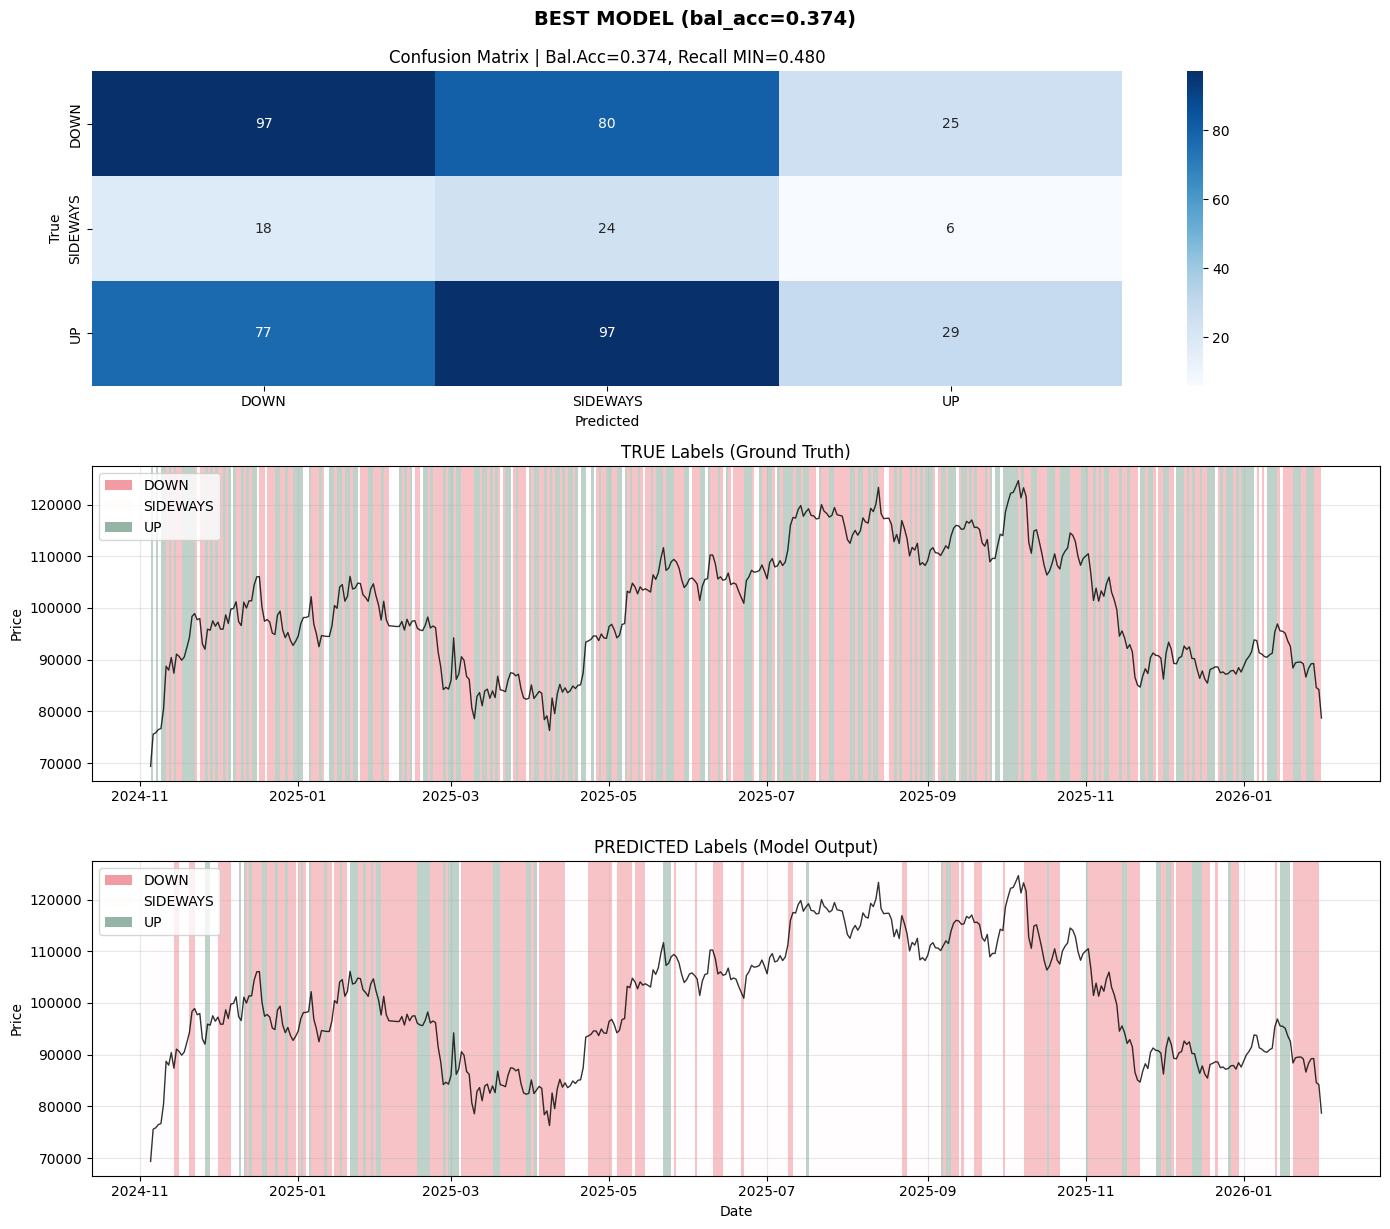


✓ Best model evaluation complete!


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# FINAL EVALUATION OF BEST MODEL
# ═══════════════════════════════════════════════════════════════════════════════════
# Run the best configuration with full visualization
# ═══════════════════════════════════════════════════════════════════════════════════

if not df_results.empty:
    print("\n" + "=" * 80)
    print("TRAINING BEST MODEL FOR FULL EVALUATION...")
    print("=" * 80)
    
    best = df_results.iloc[0]
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Get best label params
    # ─────────────────────────────────────────────────────────────────────────────
    best_label_params = {
        "horizon": int(best["horizon"]),
        "gauss_window": int(best["gauss_window"]),
        "gauss_std": float(best.get("gauss_std", 50.0)),
    }
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Get best feature params
    # ─────────────────────────────────────────────────────────────────────────────
    best_feature_params = {
        "coord_mode": best["coord_mode"],
        "orb_multiplier": float(best["orb_multiplier"]),
        "include_phases": True,
    }
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Get best model params
    # ─────────────────────────────────────────────────────────────────────────────
    best_model_params = {
        "max_depth": int(best["max_depth"]),
        "learning_rate": float(best["learning_rate"]),
        "n_estimators": int(best.get("n_estimators", 500)),
        "weight_power": float(best["weight_power"]),
    }
    
    print(f"\nBest Label Params: {best_label_params}")
    print(f"Best Feature Params: {best_feature_params}")
    print(f"Best Model Params: {best_model_params}")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Rebuild dataset with best params
    # ─────────────────────────────────────────────────────────────────────────────
    df_labels_best = get_or_compute_labels(df_market, best_label_params)
    df_features_best = get_or_compute_features(df_market, settings, best_feature_params)
    df_dataset_best = merge_features_with_labels(df_features_best, df_labels_best)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Train and evaluate with visualization
    # ─────────────────────────────────────────────────────────────────────────────
    final_metrics, final_model = train_and_evaluate_full(
        df_dataset_best,
        best_model_params.copy(),
        device,
        title=f"BEST MODEL (bal_acc={best['bal_acc']:.3f})",
        df_market=df_market,
    )
    
    print("\n✓ Best model evaluation complete!")
else:
    print("⚠️ No grid search results to evaluate")


TOP 5 by UP/DOWN balance:
   horizon  orb_multiplier coord_mode  sideways_penalty  max_depth  \
0        1            0.15      helio               1.0          9   
1        1            0.15      helio               1.0          9   
2        1            0.15      helio               1.0          5   
3        1            0.15      helio               1.0          9   
4        1            0.15       both               0.5          9   

   learning_rate  recall_down  recall_up  up_down_min  
0           0.03     0.480198   0.500000     0.480198  
1           0.03     0.480583   0.444444     0.444444  
2           0.05     0.420792   0.416667     0.416667  
3           0.01     0.402913   0.644444     0.402913  
4           0.05     0.422886   0.382979     0.382979  


EVALUATING RANK #1
Label: {'horizon': 1, 'gauss_window': 201, 'gauss_std': 50.0}
Feature: {'coord_mode': 'helio', 'orb_multiplier': 0.15, 'include_phases': True}
Model: {'max_depth': 9, 'learning_rate': 0.03, 'n_est

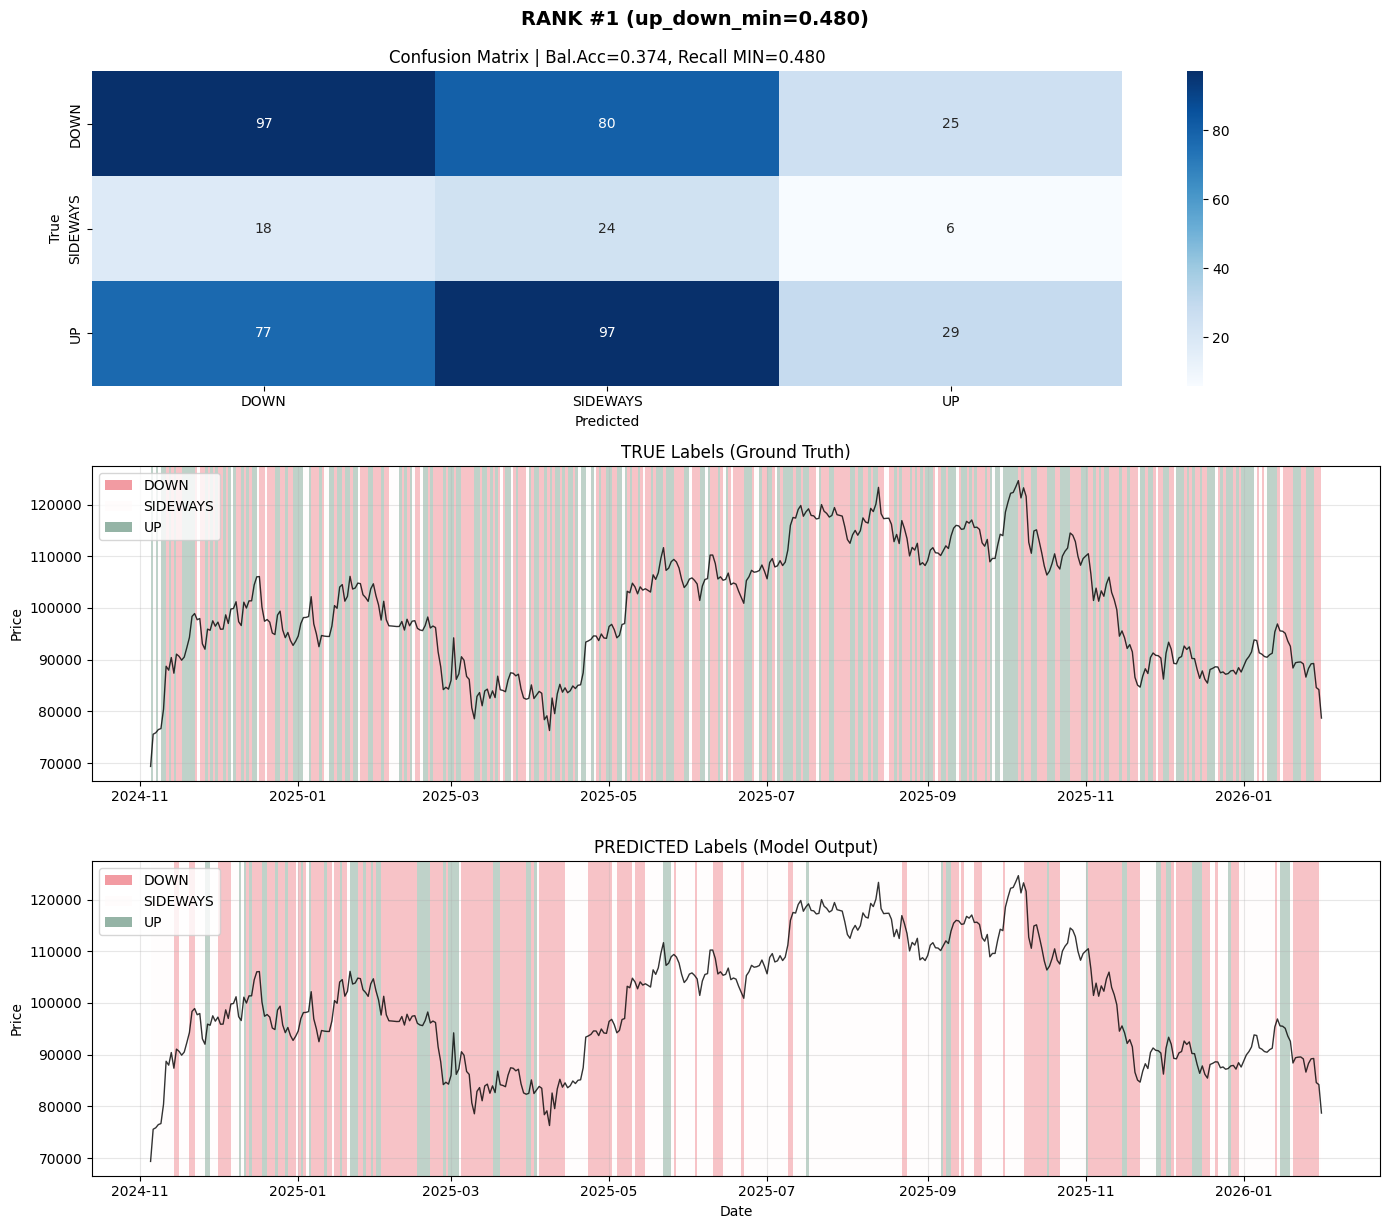



EVALUATING RANK #2
Label: {'horizon': 1, 'gauss_window': 201, 'gauss_std': 100.0}
Feature: {'coord_mode': 'helio', 'orb_multiplier': 0.15, 'include_phases': True}
Model: {'max_depth': 9, 'learning_rate': 0.03, 'n_estimators': 500, 'weight_power': 2.0, 'sideways_penalty': 1.0}
Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 91
Split: Train=2109, Val=452, Test=453
Training model with weight_power=2.0...

  RANK #2 (up_down_min=0.444)

📊 METRICS:
  Accuracy:          0.3554
  Balanced Accuracy: 0.3776
  MCC:               0.0637
  F1 Macro:          0.3241

📈 PER-CLASS RECALL:
  DOWN (0):     0.4806
  SIDEWAYS (1): 0.4444
  UP (2):       0.4444

🎯 RECALL MIN:  0.4444 (quality)
   RECALL GAP:  0.0361 (balance)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        DOWN       0.53      0.48      0.50       206
    SIDEWAYS       0.11      0.44      0.18        45
          UP       0.46      0.21      0.29       202

    accuracy        

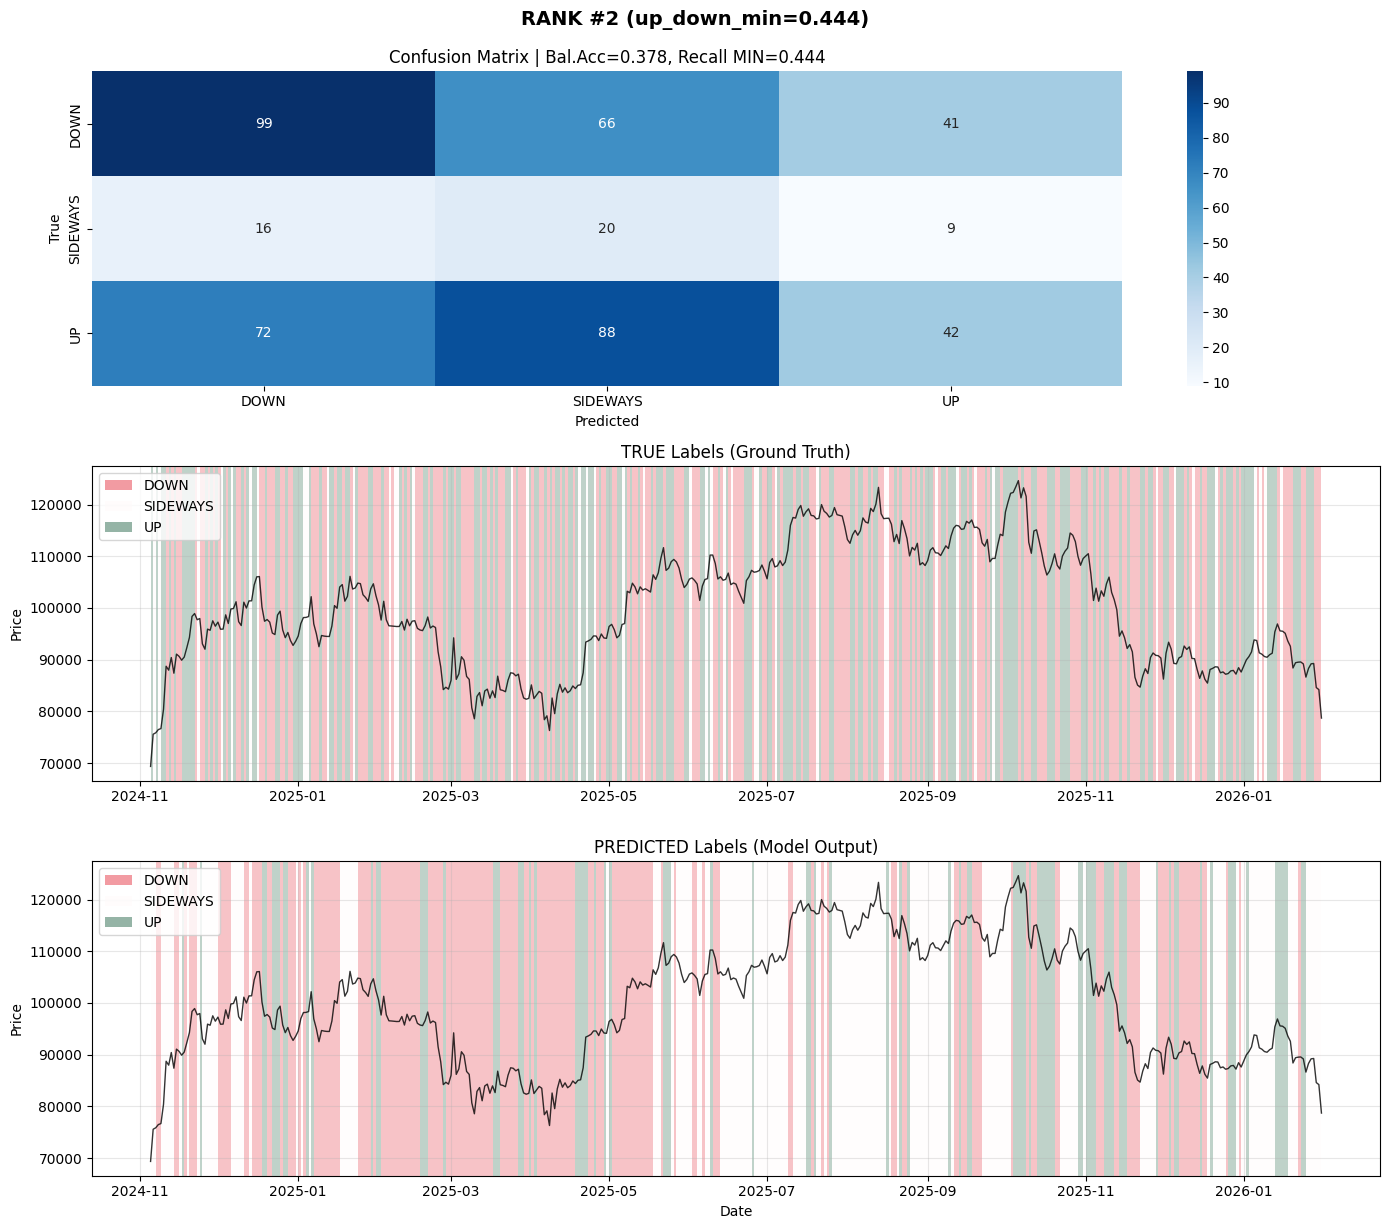



EVALUATING RANK #3
Label: {'horizon': 1, 'gauss_window': 201, 'gauss_std': 50.0}
Feature: {'coord_mode': 'helio', 'orb_multiplier': 0.15, 'include_phases': True}
Model: {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 500, 'weight_power': 2.0, 'sideways_penalty': 1.0}
Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 91
Split: Train=2109, Val=452, Test=453
Training model with weight_power=2.0...

  RANK #3 (up_down_min=0.417)

📊 METRICS:
  Accuracy:          0.3046
  Balanced Accuracy: 0.3333
  MCC:               0.0291
  F1 Macro:          0.2836

📈 PER-CLASS RECALL:
  DOWN (0):     0.4208
  SIDEWAYS (1): 0.4167
  UP (2):       0.4167

🎯 RECALL MIN:  0.4167 (quality)
   RECALL GAP:  0.0041 (balance)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        DOWN       0.49      0.42      0.45       202
    SIDEWAYS       0.09      0.42      0.15        48
          UP       0.49      0.16      0.24       203

    accuracy         

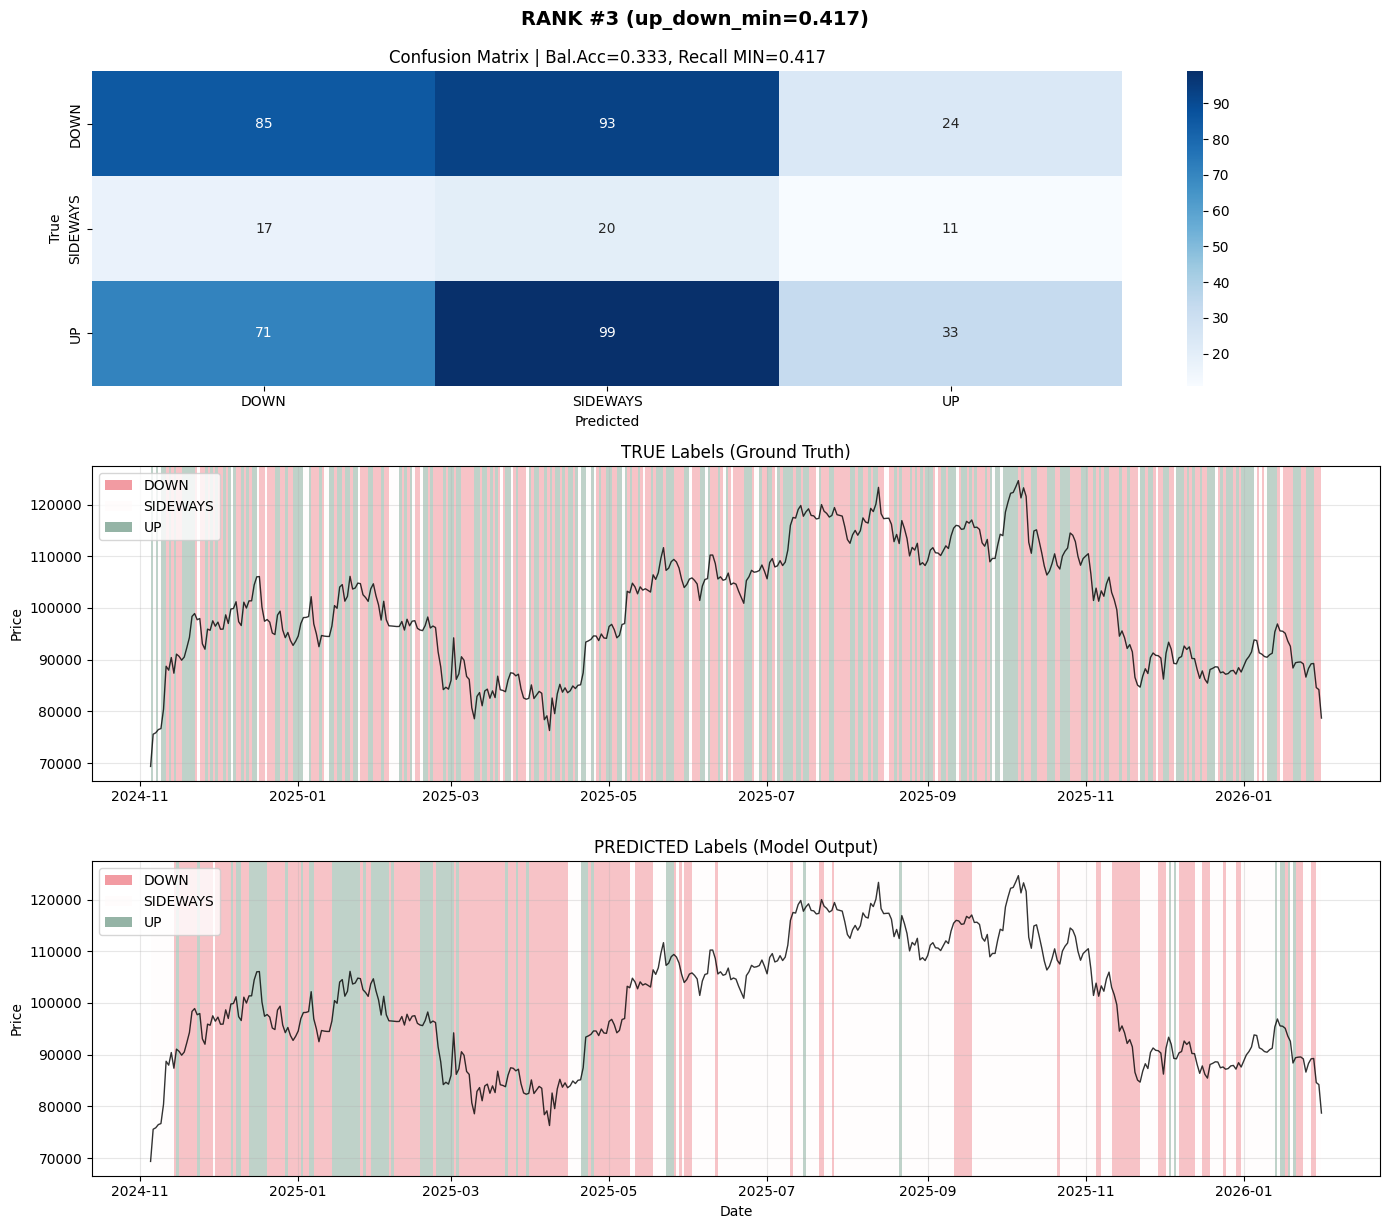



EVALUATING RANK #4
Label: {'horizon': 1, 'gauss_window': 201, 'gauss_std': 100.0}
Feature: {'coord_mode': 'helio', 'orb_multiplier': 0.15, 'include_phases': True}
Model: {'max_depth': 9, 'learning_rate': 0.01, 'n_estimators': 500, 'weight_power': 2.0, 'sideways_penalty': 1.0}
Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 91
Split: Train=2109, Val=452, Test=453
Training model with weight_power=2.0...

  RANK #4 (up_down_min=0.403)

📊 METRICS:
  Accuracy:          0.3046
  Balanced Accuracy: 0.3920
  MCC:               0.0616
  F1 Macro:          0.2872

📈 PER-CLASS RECALL:
  DOWN (0):     0.4029
  SIDEWAYS (1): 0.6444
  UP (2):       0.6444

🎯 RECALL MIN:  0.4029 (quality)
   RECALL GAP:  0.2415 (balance)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        DOWN       0.53      0.40      0.46       206
    SIDEWAYS       0.12      0.64      0.21        45
          UP       0.44      0.13      0.20       202

    accuracy        

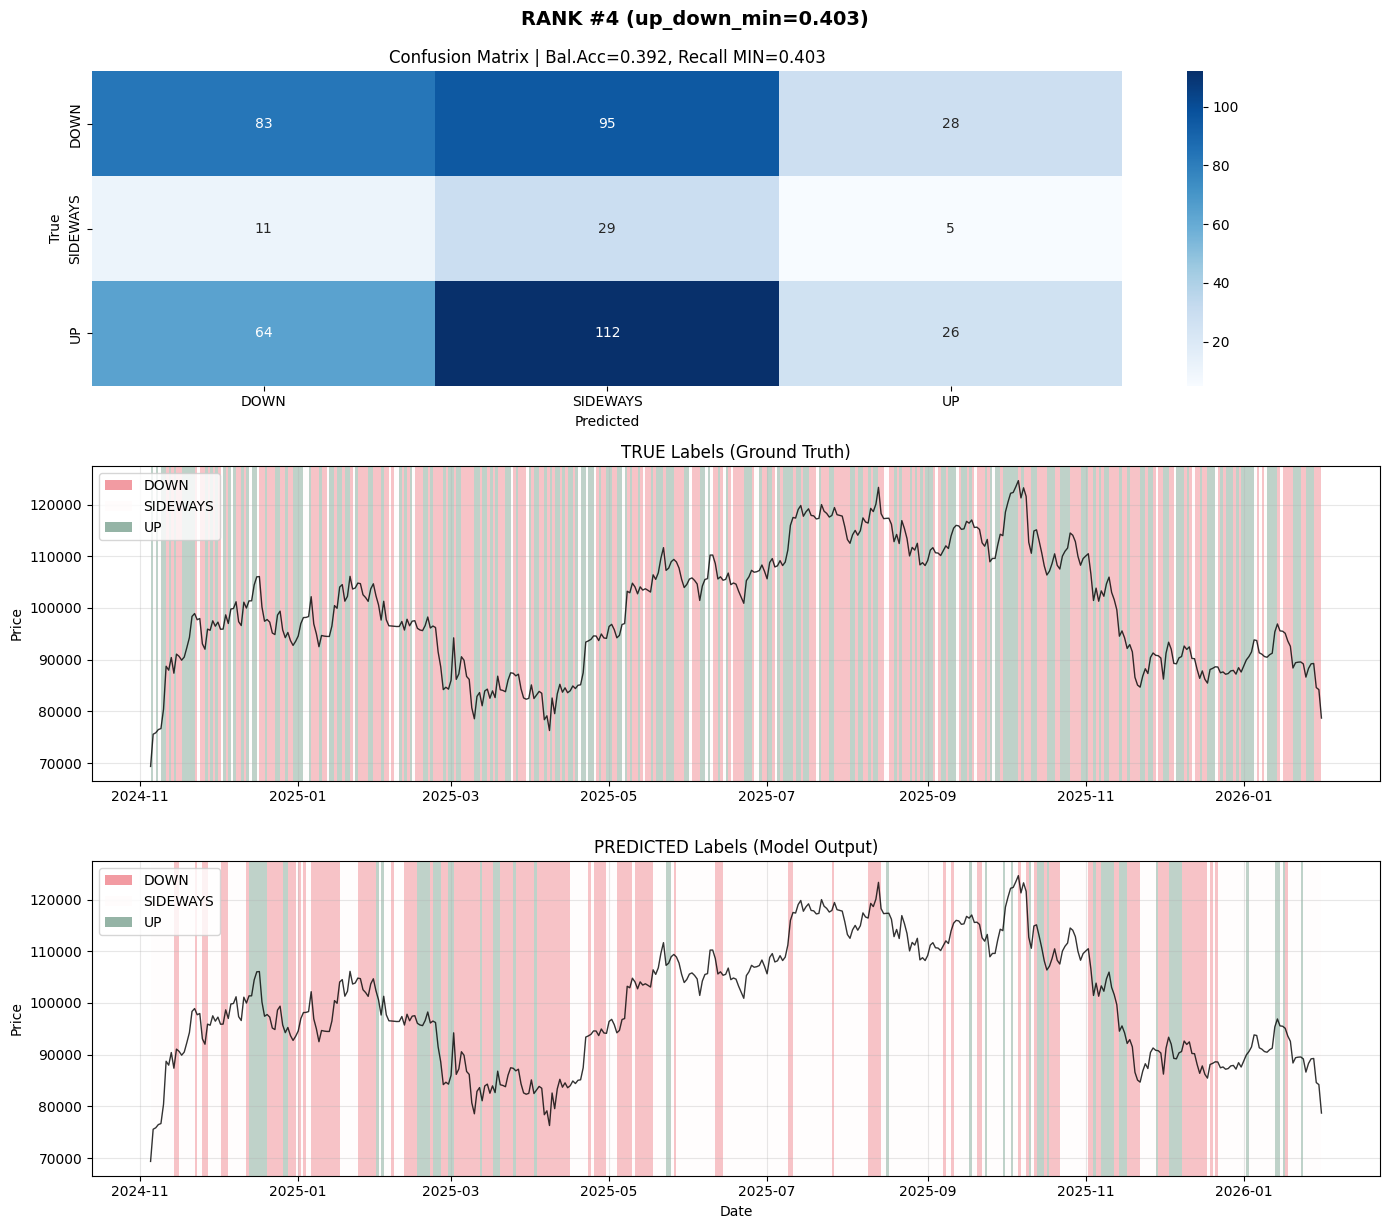



EVALUATING RANK #5
Label: {'horizon': 1, 'gauss_window': 101, 'gauss_std': 50.0}
Feature: {'coord_mode': 'both', 'orb_multiplier': 0.15, 'include_phases': True}
Model: {'max_depth': 9, 'learning_rate': 0.05, 'n_estimators': 500, 'weight_power': 2.0, 'sideways_penalty': 0.5}
Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 834
Split: Train=2109, Val=452, Test=453
Training model with weight_power=2.0...

  RANK #5 (up_down_min=0.383)

📊 METRICS:
  Accuracy:          0.3311
  Balanced Accuracy: 0.3450
  MCC:               0.0327
  F1 Macro:          0.3065

📈 PER-CLASS RECALL:
  DOWN (0):     0.4229
  SIDEWAYS (1): 0.3830
  UP (2):       0.3830

🎯 RECALL MIN:  0.3830 (quality)
   RECALL GAP:  0.0399 (balance)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        DOWN       0.46      0.42      0.44       201
    SIDEWAYS       0.10      0.38      0.16        47
          UP       0.53      0.23      0.32       205

    accuracy         

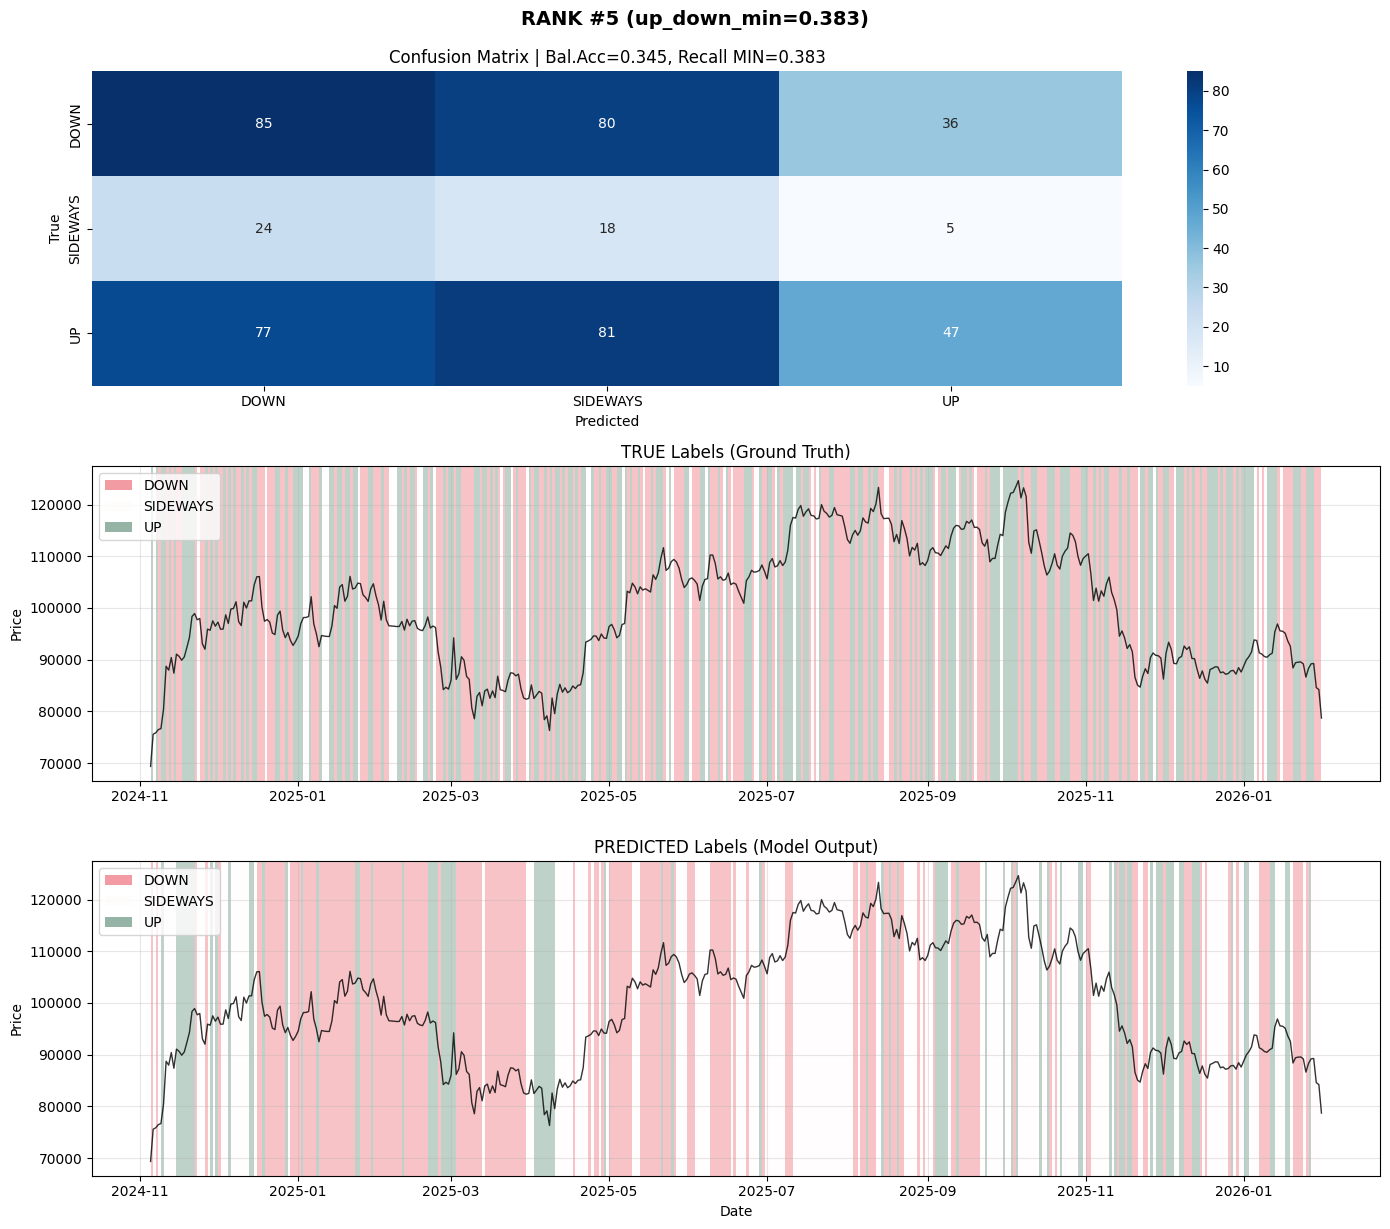

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════════
# EVALUATE TOP 2 CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════════════════

# Sort by UP/DOWN balance
df_best = df_results.sort_values(
    ["up_down_min", "up_down_gap"], 
    ascending=[False, True]
).reset_index(drop=True)

print("TOP 5 by UP/DOWN balance:")
print(df_best[["horizon", "orb_multiplier", "coord_mode", "sideways_penalty", 
               "max_depth", "learning_rate", "recall_down", "recall_up", "up_down_min"]].head())

# Evaluate TOP 2
for rank in range(5):
    best = df_best.iloc[rank]
    
    print(f"\n\n{'='*80}")
    print(f"EVALUATING RANK #{rank+1}")
    print(f"{'='*80}")
    
    best_label_params = {
        "horizon": int(best["horizon"]),
        "gauss_window": int(best["gauss_window"]),
        "gauss_std": float(best.get("gauss_std", 50.0)),
    }
    
    best_feature_params = {
        "coord_mode": best["coord_mode"],
        "orb_multiplier": float(best["orb_multiplier"]),
        "include_phases": True,
    }
    
    best_model_params = {
        "max_depth": int(best["max_depth"]),
        "learning_rate": float(best["learning_rate"]),
        "n_estimators": 500,
        "weight_power": float(best.get("weight_power", 2.0)),
        "sideways_penalty": float(best.get("sideways_penalty", 1.0)),
    }
    
    print(f"Label: {best_label_params}")
    print(f"Feature: {best_feature_params}")
    print(f"Model: {best_model_params}")
    
    # Rebuild dataset
    df_labels_best = get_or_compute_labels(df_market, best_label_params)
    df_features_best = get_or_compute_features(df_market, settings, best_feature_params)
    df_dataset_best = merge_features_with_labels(df_features_best, df_labels_best)
    
    # Train and evaluate
    metrics, model = train_and_evaluate_full(
        df_dataset_best,
        best_model_params.copy(),
        device,
        title=f"RANK #{rank+1} (up_down_min={best['up_down_min']:.3f})",
        df_market=df_market,
    )